In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Evaluating & Checking Process for finding an optimal fraction of the best featurs for training the Binary ML model.

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


In [3]:
datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
}

data_dict = {}
for name, url in datasets.items():
    data = pd.read_csv(url, header=None)

    if name == 'us_crime':
        data = data.drop(columns=[3])
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(float).apply(lambda x: 1 if x > 0.65 else 0).astype(int)  # Target is the last column
    elif name == 'letter_img':
        X = data.iloc[1:, 1:]  # Features start from the second column
        y = data.iloc[1:, 0].apply(lambda x: 1 if x == 'Z' else 0).astype(int)   # Target is the first column
    elif name == 'mammography':
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(int)  # Target is the last column
    data_dict[name] = (X, y)


In [4]:
def calculate_f1_scores_multiple_splits(X, y, num_splits= 5): # POINT: MORE num_splits FOR MORE ACCURATE RESULTS (real features ranking).
    start_time = time.time()  # Record start time

    # multiple splits (tests) for having a more reliable and accurate evaluating features.
    f1_scores = []
    for _ in range(num_splits):
      random_state = np.random.randint(100) # Generate a random seed
      for i in range(X.shape[1]):
          X_feature = X.iloc[:, i].values.reshape(-1, 1)

          # Convert '?' to NaN and then impute missing values
          X_feature = np.where(X_feature == '?', np.nan, X_feature)
          imputer = SimpleImputer(strategy='median') # Or another suitable strategy
          X_feature = imputer.fit_transform(X_feature)

          X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.25, random_state= random_state)
          # random_state for having the mix of examples.


          clf = DecisionTreeClassifier()
          clf.fit(X_train, y_train)
          y_pred = clf.predict(X_test)

          average = 'binary'
          f1 = f1_score(y_test, y_pred, average= average)
          f1_scores.append(f1)

    end_time = time.time()  # Record end time
    execution_time = end_time - start_time  # Calculate execution time

    return np.array(f1_scores).reshape(num_splits, -1), execution_time/ num_splits # Reshape for easy averaging and returning time


In [5]:
def evaluate_svm_with_selected_features_multiple_splits(X, y, feature_ranking, fractions, num_splits= 5): # POINT: MORE num_splits FOR MORE ACCURATE RESULTS (real outcomes of fractions).
    results_all= []
    for _ in range(num_splits):
      random_state= np.random.randint(100)
      results = {'fraction': [], 'f1_score': [], 'precision': [], 'recall': []}
      for fraction in fractions:
          num_features = max(1, int(fraction * X.shape[1])) # ensure that at least one feature is selected.
          selected_features = feature_ranking[:num_features]
          X_selected = X.iloc[:, selected_features]

          # Convert '?' to NaN and then impute missing values (Only for X)
          X_selected = np.where(X_selected == '?', np.nan, X_selected)
          imputer = SimpleImputer(strategy='median') # median is better than mean (maybe because of the outlier data in datasets.)
          X_selected = imputer.fit_transform(X_selected)

          X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state= random_state)

          scaler = StandardScaler()
          X_train = scaler.fit_transform(X_train)
          X_test = scaler.transform(X_test)

          svm = SVC(kernel='rbf', class_weight= 'balanced')
          svm.fit(X_train, y_train)
          y_pred = svm.predict(X_test)

          average = 'binary'
          f1 = f1_score(y_test, y_pred, average= average)
          precision = precision_score(y_test, y_pred, average= average)
          recall = recall_score(y_test, y_pred, average= average)

          results['fraction'].append(fraction)
          results['f1_score'].append(f1)
          results['precision'].append(precision)
          results['recall'].append(recall)
      results_all.append(results)
    return results_all


In [30]:
features_f1_scores

array([0.78934136, 0.56793769, 0.75545535, 0.71883216, 0.        ])

In [31]:
f1_scores_multiple

array([[0.80542986, 0.54271357, 0.76923077, 0.73913043, 0.        ],
       [0.81218274, 0.57281553, 0.76190476, 0.69444444, 0.        ],
       [0.76190476, 0.54285714, 0.74137931, 0.66949153, 0.        ],
       [0.8159204 , 0.60287081, 0.72380952, 0.72246696, 0.        ],
       [0.75126904, 0.57843137, 0.78095238, 0.76862745, 0.        ]])

Evaluating dataset: us_crime
  X shape: (1994, 126)
  y shape: (1994,)
  Ratio: 12:1
Feature evaluation for us_crime, took 1.70 seconds.
Average time per feature: 0.0135 seconds.


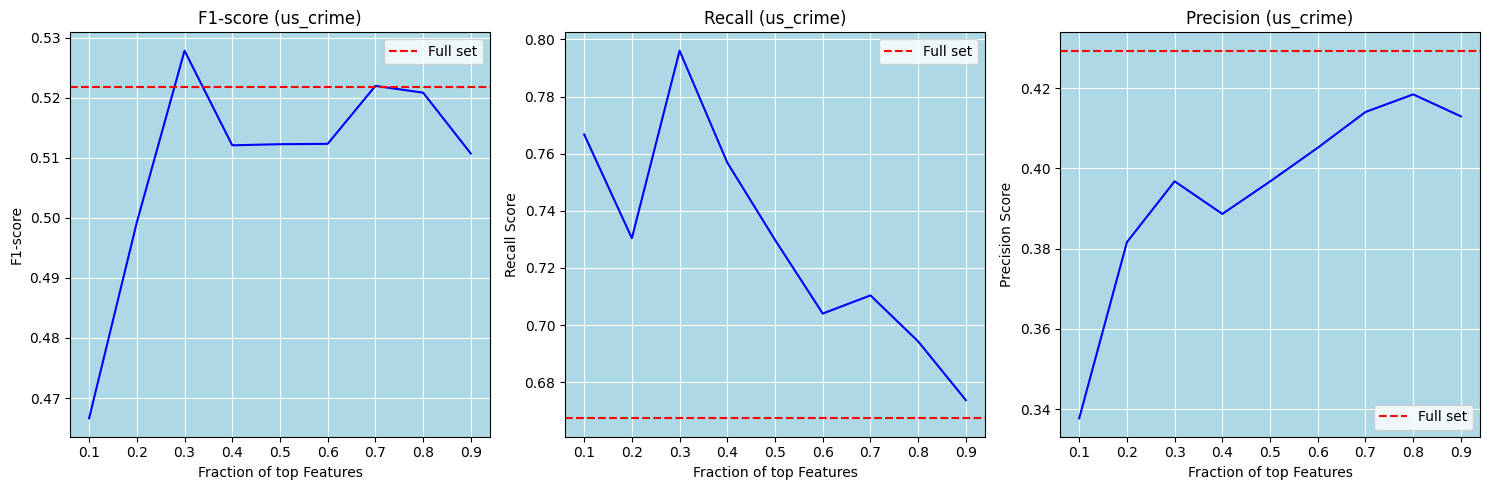

The best fraction of top features in this problem based on the F1-score is 0.3 with F1-score of 0.5278533024804124
Therefore we can use the 0.3 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: PctKids2Par:49, F1-score based Rank: 1, F1-score: 0.496202
Feature: PctTeen2Par:51, F1-score based Rank: 2, F1-score: 0.425156
Feature: PctIlleg:55, F1-score based Rank: 3, F1-score: 0.377566
Feature: PctFam2Par:48, F1-score based Rank: 4, F1-score: 0.351283
Feature: PctYoungKids2Par:50, F1-score based Rank: 5, F1-score: 0.329648
Feature: racePctWhite:8, F1-score based Rank: 6, F1-score: 0.326491
Feature: NumIlleg:54, F1-score based Rank: 7, F1-score: 0.259799
Feature: RacialMatchCommPol:109, F1-score based Rank: 8, F1-score: 0.241286
Feature: NumUnderPov:32, F1-score based Rank: 9, F1-score: 0.236412
Feature: PctPolicWhite:110, F1-score based Rank: 10, F1-score: 0.226842
Feature: racepctblack:7, F1-score based Rank: 11, F1-score: 0.222

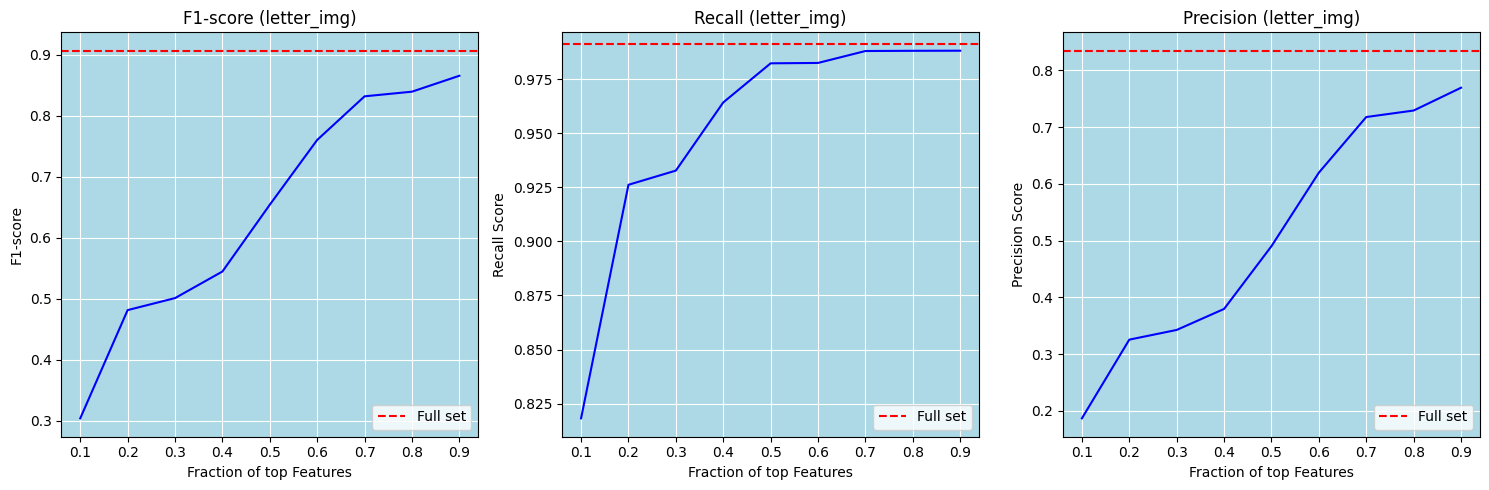

The best fraction of top features in this problem based on the F1-score is 1.0 with F1-score of 0.9062199855568146
Therefore we can use the 1.0 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: y2bar:9, F1-score based Rank: 1, F1-score: 0.317018
Feature: high:4, F1-score based Rank: 2, F1-score: 0.004184
Feature: y-ege:15, F1-score based Rank: 3, F1-score: 0.002174
Feature: yegvx:16, F1-score based Rank: 4, F1-score: 0.000000
Feature: xegvy:14, F1-score based Rank: 5, F1-score: 0.000000
Feature: x-ege:13, F1-score based Rank: 6, F1-score: 0.000000
Feature: xy2br:12, F1-score based Rank: 7, F1-score: 0.000000
Feature: x2ybr:11, F1-score based Rank: 8, F1-score: 0.000000
Feature: xybar:10, F1-score based Rank: 9, F1-score: 0.000000
Feature: x2bar:8, F1-score based Rank: 10, F1-score: 0.000000
Feature: y-bar:7, F1-score based Rank: 11, F1-score: 0.000000
Feature: x-bar:6, F1-score based Rank: 12, F1-score: 0.000000
Feature: onpix

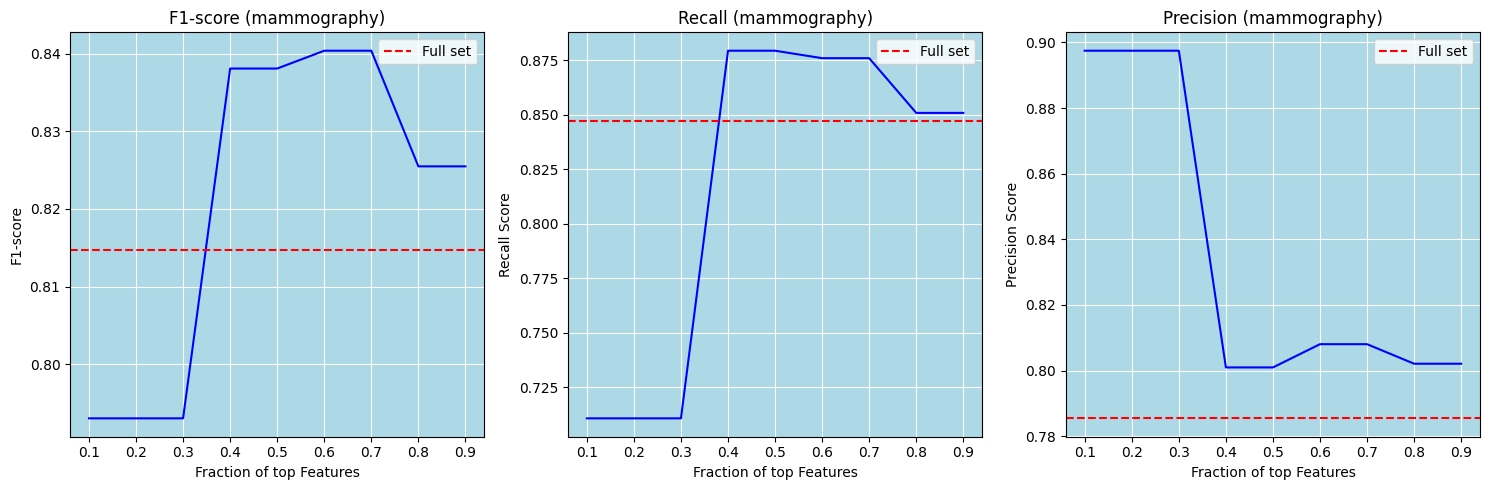

The best fraction of top features in this problem based on the F1-score is 0.6 with F1-score of 0.8403597688989344
Therefore we can use the 0.6 fraction of top features as an optima.
Features (from highest to lowest score) as an optimal subset:
Feature: BI-RADS:0, F1-score based Rank: 1, F1-score: 0.797004
Feature: Shape:2, F1-score based Rank: 2, F1-score: 0.766441
Feature: Margin:3, F1-score based Rank: 3, F1-score: 0.722051
Saved dataset with optimal feature set for mammography to mammography_optimal.csv
************************************************** 



In [14]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # POINT: MORE FRACTIONS FOR MORE ACCURATE RESULTS (real number of features).
# these three following lists are for the last summary metrics.
optimal_fractions= []
optimal_f1_scores= []
full_set_f1_scores= []

for name, (X, y) in data_dict.items():
    print(f"Evaluating dataset: {name}")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    unique, counts = np.unique(y, return_counts=True)
    ratio = int(counts[np.argmax(counts)] / counts[np.argmin(counts)])
    print(f"  Ratio: {ratio}:1")
    # print("\n")

    f1_scores_multiple, eval_duration = calculate_f1_scores_multiple_splits(X, y)

    features_f1_scores= f1_scores_multiple.mean(axis=0) # Average across rows (splits)
    print(f"Feature evaluation for {name}, took {eval_duration:.2f} seconds.")  # Display all features evaluation execution time.
    print(f"Average time per feature: {eval_duration/ X.shape[1]:.4f} seconds.")  # Display average feature time.

    # Rank features based on F1-scores
    feature_ranking = np.argsort(features_f1_scores)[::-1]

    # Evaluate SVM classifier with selected features
    results_multiple = evaluate_svm_with_selected_features_multiple_splits(X, y, feature_ranking, fractions)

    # Calculate average scores for each fraction
    average_f1_scores = []
    average_precision_scores = []
    average_recall_scores = []

    for fraction in fractions:
        f1_scores_for_fraction = [result['f1_score'][fractions.index(fraction)] for result in results_multiple]
        precision_scores_for_fraction = [result['precision'][fractions.index(fraction)] for result in results_multiple]
        recall_scores_for_fraction = [result['recall'][fractions.index(fraction)] for result in results_multiple]

        average_f1_scores.append(np.mean(f1_scores_for_fraction))
        average_precision_scores.append(np.mean(precision_scores_for_fraction))
        average_recall_scores.append(np.mean(recall_scores_for_fraction))

    # Now we have average scores for each fraction across multiple splits
    # Use these average scores for plotting instead of the single-split scores
    f1_scores = average_f1_scores
    recall_scores = average_recall_scores
    precision_scores = average_precision_scores
    # # Extract the scores for plotting
    # f1_scores = results['f1_score']
    # recall_scores = results['recall']
    # precision_scores = results['precision']

    # Plot the results
    plt.figure(figsize=(15, 5))

    # Plot F1-score
    plt.subplot(1, 3, 1)
    plt.plot(fractions[: -1], f1_scores[: -1], color= "blue")
    plt.axhline(y= f1_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'F1-score ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('F1-score')
    plt.grid(True, color='white')
    plt.gca().set_facecolor('lightblue')
    plt.grid(True)
    plt.legend()

    # Plot Recall score
    plt.subplot(1, 3, 2)
    plt.plot(fractions[: -1], recall_scores[: -1], color= "blue")
    plt.axhline(y= recall_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'Recall ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('Recall Score')
    plt.grid(True, color='white')
    plt.gca().set_facecolor('lightblue')
    plt.grid(True)
    plt.legend()

    # Plot Precision score
    plt.subplot(1, 3, 3)
    plt.plot(fractions[: -1], precision_scores[: -1], color= "blue")
    plt.axhline(y= precision_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'Precision ({name})')
    plt.xlabel('Fraction of top Features')
    plt.ylabel('Precision Score')
    plt.grid(True, color='white')  # White grid lines
    plt.gca().set_facecolor('lightblue')  # Light blue background
    plt.grid(True)

    plt.tight_layout()
    plt.legend()
    plt.show()
    optimal_f1_score= max(f1_scores) # related to the optimal fraciton of all fractions.
    optimal_fraction= fractions[f1_scores.index(optimal_f1_score)]
    print(f"The best fraction of top features in this problem based on the F1-score is {optimal_fraction} with F1-score of {optimal_f1_score:.6f}.")
    print(f"Therefore we can use the {optimal_fraction} fraction of top features as an optima.")

    optimal_fractions.append(optimal_fraction)
    optimal_f1_scores.append(optimal_f1_score)

    full_set_f1_scores.append(f1_scores[-1])

    num_optimal_features = int(optimal_fraction * X.shape[1])
    optimal_feature_indices = feature_ranking[:num_optimal_features]
    print(f"Features (from highest to lowest score) as an optimal subset:")

    ########
    # having the names of features (again)!
    datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
    }
    data_reimport = pd.read_csv(datasets[name], header=0)
    if name == 'us_crime':
        data_reimport = data_reimport.drop(columns=['communityname']) #dropping string value feature
        X_reimport = data_reimport.iloc[1:, :-1] # 1: confident starting row.
    elif name == 'letter_img':
        X_reimport = data_reimport.iloc[1:, 1:]  # Features start from the second column
    elif name == 'mammography':
        X_reimport = data_reimport.iloc[1:, :-1]
    ########

    for index in optimal_feature_indices:
        feature_loc = X.columns[index]
        feature_name= X_reimport.columns[index]
        rank = np.where(feature_ranking == index)[0][0] + 1 # Calculate rank in the sorted feature_ranking list (1-based)
        f1_score_value = features_f1_scores[index]  # Get feature F1-score (f1_scores is 0-based)
        print(f"Feature: {feature_name}:{feature_loc}, F1-score based Rank: {rank}, F1-score: {f1_score_value:.6f}")

    # Saving the new csv file for future training and testing with features modified:
    X_optimal = X_reimport.iloc[:, optimal_feature_indices]
    # X_optimal = np.where(X_optimal == '?', np.nan, X_optimal)
    # imputer = SimpleImputer(strategy='median') # the same as what is done in the process.
    # X_optimal = imputer.fit_transform(X_optimal) # it should convert back to a Pandas DataFrame.
    y = y.rename("Target")  # Rename the target column from a numerical value.

    optimal_df = pd.concat([X_optimal, y], axis=1)  # Combine features and target
    optimal_df.to_csv(f"{name}_optimal.csv", index=False)  # Save to CSV
    print(f"Saved dataset with optimal feature set for {name} to {name}_optimal.csv")

    print(50* '*', '\n')


This shows us that we do not necessarily need to use all the features and also more than one induvidual feature lead to a good ML model.

## **Summary Metric:**

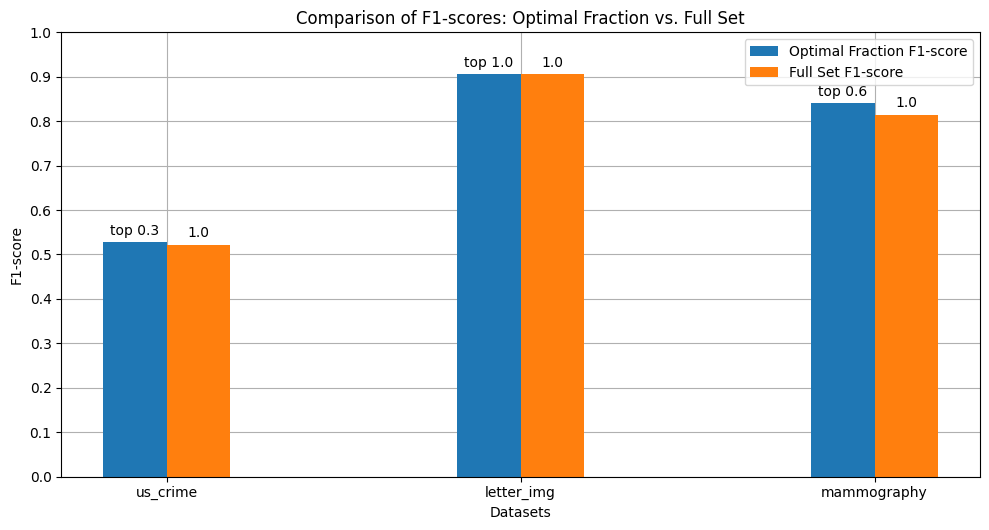

In [37]:
# Summary metrics of optimal fractions of top features vs. full set of features.

dataset_names = list(data_dict.keys())
bar_width = 0.18
index = np.arange(len(dataset_names))

plt.figure(figsize=(10, 5.4))
plt.bar(index, optimal_f1_scores, bar_width, label='Optimal Fraction F1-score', zorder= 2)
plt.bar(index + bar_width, full_set_f1_scores, bar_width, label='Full Set F1-score', zorder= 2)

plt.xlabel('Datasets')
plt.ylabel('F1-score')
plt.title('Comparison of F1-scores: Optimal Fraction vs. Full Set')
plt.xticks(index + bar_width / 2, dataset_names)
plt.legend()
plt.tight_layout()
for i, (optimal_f1, full_f1) in enumerate(zip(optimal_f1_scores, full_set_f1_scores)):
  plt.text(index[i], optimal_f1 + 0.01, f"top {optimal_fractions[i]:.1f}", ha='center', va='bottom')
  plt.text(index[i] + bar_width, full_f1 + 0.01, "1.0", ha='center', va='bottom')

plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks with a step of 0.1
plt.grid(True, zorder= 0)
plt.show()